### Laboratory of Computational Physics Mod. B 
#### Students

- Marchetti Andrea - 2089216 - andrea.marchetti.5@studenti.unipd.it
- Menti Luca  - 2069534 - luca.menti@studenti.unipd.it
- Merlin Giovanni - 2091186 - giovanni.merlin@studenti.unipd.it
- Saretto Alberto - 2063139 - alberto.saretto.1@studenti.unipd.it

# EXERCISE 4 - XGBoost

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras,sklearn
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
from scipy.interpolate import make_interp_spline

#import DecisionTreeClass for AdaBoost
from sklearn.tree import DecisionTreeClassifier as DecTree

plt.rcParams['font.size'] = 14

In [61]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD,RMSprop,Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Rescaling, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

In [62]:
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

XGBoost version: 1.7.5


### Dataset generation

Generate a synthetic dataset, uniformly in a 2D box between -S and S. Subsequently, split it between training and test set. 

In [63]:
np.random.seed(123)

CASE = 1

S = 2
N = 40000
N_train = 20000
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)



#Modify this to have a defferent dataset 
for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

# Stack the arrays horizontally
train = np.column_stack((x_train, y_train))
test = np.column_stack((x_test, y_test))

# Save the arrays to a CSV file
np.savetxt('train.csv', train, delimiter=',')
np.savetxt('test.csv', test, delimiter=',')

Visualize the dataset

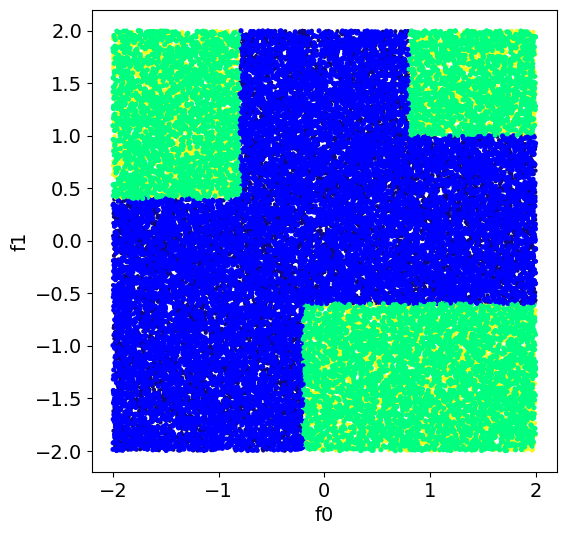

In [65]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")


plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

# PART 1

Function to train the classifier specified and subsequently to test it on the training set, showing the accuracy and plotting the edges of the decision boundary.

In [66]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    #if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    if show:   

        # scatter plot
        dx = 0.02
        x_seq=np.arange(-S,S+dx,dx)
        nx = len(x_seq)
        x_plot=np.zeros((nx*nx,2))

        q=0
        for i in range(nx):
            for j in range(nx):
                x_plot[q,:] = [x_seq[i],x_seq[j]]
                q+=1
                
        y_plot= clf.predict(x_plot)

        plt.figure(figsize=(6,6))
        plt.title(str(clf))

        scat(x_plot,y_plot,cmap='winter', s=1)
        scat(x_train,y_train,s=7)
        plt.show()

        # tree plot
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

    return clf.score(x_test, y_test)

Function to create a training and a test set of the desired length, out of from the same dataset.

In [67]:
def create_sets(N_train, N_test):

    # Load the data from the CSV file
    train = np.loadtxt('train.csv', delimiter=',')
    test = np.loadtxt('test.csv', delimiter=',')

    # Extract the first two columns into x and the last column into y
    x_tr = train[:N_train, :2]
    y_tr = train[:N_train, 2]

    # Extract the first two columns into x and the last column into y
    x_te = test[:N_test, :2]
    y_te = test[:N_test, 2]

    return x_tr, y_tr, x_te, y_te

## XGBoost: model training

Train three different kinds of model offered by the xgboost package, on training sets of different sizes.

In [85]:
import graphviz

N_test = 1000
N_train = [100,500,1000,5000,10000,20000]

scores_XGB = []

for n in N_train:
    
    x_train, y_train, x_test, y_test = create_sets(n,N_test)
    
    score = classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=0.001, n_estimators=3, gamma=1, max_depth = 3),show=False)

    scores_XGB.append(score)    

In [69]:
scores_gb = []

for n in N_train:
    
    x_train, y_train, x_test, y_test = create_sets(n,N_test)
    
    score = classify(GradientBoostingClassifier(learning_rate=0.4,
                        n_estimators=3),show=False)

    scores_gb.append(score) 

In [70]:
scores_ada = []

for n in N_train:
    
    x_train, y_train, x_test, y_test = create_sets(n,N_test)
    
    score = classify(AdaBoostClassifier(learning_rate=0.4,
                        n_estimators=3),show=False)

    scores_ada.append(score) 

## Neural Network

Functions to create an NN

In [71]:
#L = len(x[0])
L=2

# define the create_DNN function
def create_DNN(units=20, activation='elu', dropout=0.01, hid_layers=1, scale=1/50):

    # instantiate model
    model = Sequential()
    model.add(Dense(L, input_shape=(L,), activation=activation))

    for i in range(hid_layers):
        model.add(Dense(units, activation=activation))

    model.add(Dropout(dropout))
    #model.add(keras.layers.Rescaling(scale=scale))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# define the compile_model function
def compile_model(lr=0.1, optimizer="Adam", units=20, activation='relu', dropout=0.01, rescale=1/50):


    # create the model
    model = create_DNN(units=units, activation=activation, dropout=dropout)

    # compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


Train different NNs on training sets of different sizes.

In [82]:
N_train = [100,500,1000,5000,10000,20000]
N_test = 1000

# training parameters
batch_size = 100
epochs = 1000

show = False

histories= np.array([])
scores = np.array([])
accuracies = np.array([])

for i in N_train:

    x_train, y_train, x_test, y_test = create_sets(i,N_test)  

    # create the deep neural net
    DNN = compile_model(lr=10)  

    # train DNN and store training info in history
    history = DNN.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(x_test, y_test))

    # evaluate model on validation set
    score = DNN.evaluate(x_test, y_test, verbose=0)

    print('Performance considering ',i, ' samples')
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])


    # summarize history2 for accuracy
    if show == True:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.ylabel('model accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

        # summarize history2 for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel('model loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

    histories = np.append(histories, history)
    scores = np.append(scores, score)
    NN_acc = np.append(NN_acc, score[1])


Performance considering  100  samples
Performance considering  500  samples
Performance considering  1000  samples
Performance considering  5000  samples
Performance considering  10000  samples
Performance considering  20000  samples


## Comparison NN vs decision trees

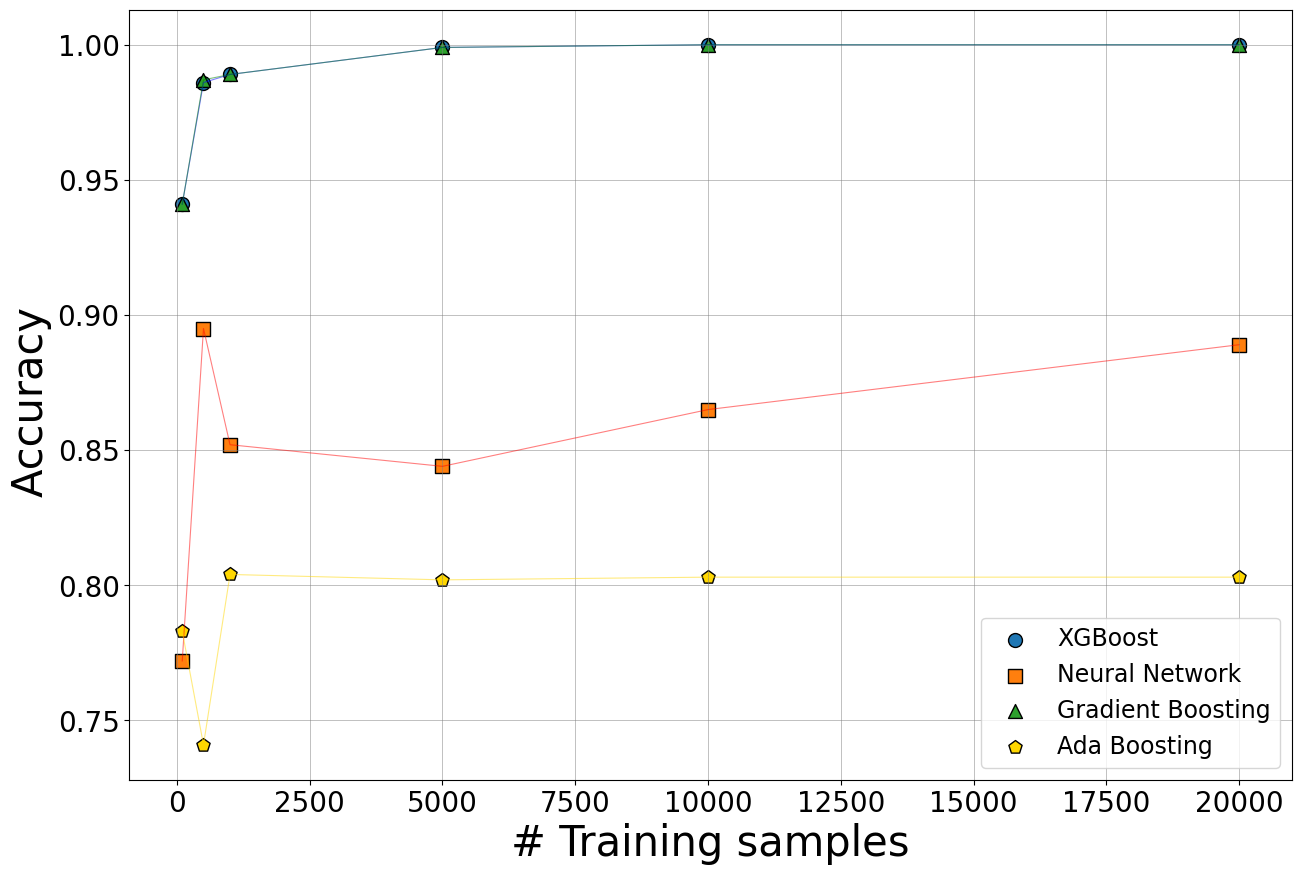

In [88]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))

ax.scatter(N_train, scores_XGB, label = "XGBoost", marker = 'o', s = 100, edgecolors='k')
ax.plot(N_train,scores_XGB, linewidth = 0.8, color = 'b', alpha = 0.5)

ax.scatter(N_train, NN_acc, label = "Neural Network", marker = 's', s = 100, edgecolors='k')
ax.plot(N_train,NN_acc, linewidth = 0.8, color = 'r', alpha = 0.5)

ax.scatter(N_train, scores_gb, label = "Gradient Boosting", marker = '^', s = 100, edgecolors='k')
ax.plot(N_train,scores_gb, linewidth = 0.8, color = 'g', alpha = 0.5)

ax.scatter(N_train, scores_ada, label = "Ada Boosting", marker = 'p', s = 100, color = 'gold', edgecolors='k')
ax.plot(N_train, scores_ada, linewidth = 0.8, color = 'gold', alpha = 0.5)


#ax.set_yscale('log')
ax.set_xlabel('# Training samples', fontsize=30) # set the font size of the x-axis label to 16
ax.set_ylabel('Accuracy ', fontsize=30) # set the font size of the y-axis label to 16
ax.tick_params(axis='x', labelsize=20) # set the size of the x-axis ticks to 16
ax.tick_params(axis='y', labelsize=20) # set the size of the x-axis ticks to 16
ax.legend(loc='best', fontsize=30)
ax.grid(True, linestyle='-', linewidth='0.7', color='gray', alpha=0.5)


ax.legend(fontsize = 17)

Comment on the results.  First of all, we can see that the general trend is an increase in the accuracy as the number of training samples increases, in almost all models. Secondly, that the accuracy of XGBoost and of GradientBoosting is way higher than the one of AdaBoosting and of the NN. The decision trees show some advantages with respect to the NN. Namely, their learning time is much smaller and the accuracy achieved is not so much dependent on the size of the training set (it is already optimal with 5000 training samples), differently from the NN.

# PART 2

We will now implement a grid search to find the best parameters for the different models of decision tree.

In [3]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

def gridsearch(param_grid, model_gridsearch, x_train, y_train):

    # call scikit grid search module
    grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs =1, cv=4)
    grid_result = grid.fit(x_train, y_train)

    # create a dataframe with the scores
    df = pd.DataFrame(grid_result.cv_results_)

    """df_selected.style.set_table_styles([
        {"selector": "th", "props": [("background-color", "#f2f2f2")]}
    ])"""

    return grid_result.best_score_, grid_result.best_params_, df

Define dictionaries for GridSearch and recreate the training and test set, choosing 5000 samples according the the previous comment.

### XGBoost

In [11]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
              'reg_lambda': [0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators': [1, 2, 3, 4, 10], 
              'gamma': [0, 1, 10, 100, 200], 
              'max_depth': [1, 2, 4, 6, 8, 10] 
            }

lr = {'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]}
reg_lambda = {'reg_lambda': [0.0001, 0.001, 0.01, 0.1, 1]}
estimators = {'n_estimators': [1, 2, 3, 4, 10]}
gamma = {'gamma': [0, 1, 10, 100, 200]}
max_depth = {'max_depth': [1, 2, 4, 6, 8, 10]}

#list of dictionaries to iterate on
dicts = [lr, reg_lambda, estimators, gamma, max_depth]

N_train = 5000
N_test  = 5000
x_train, y_train, x_test, y_test = create_sets(N_train,N_test)  

Test one parameter at a time

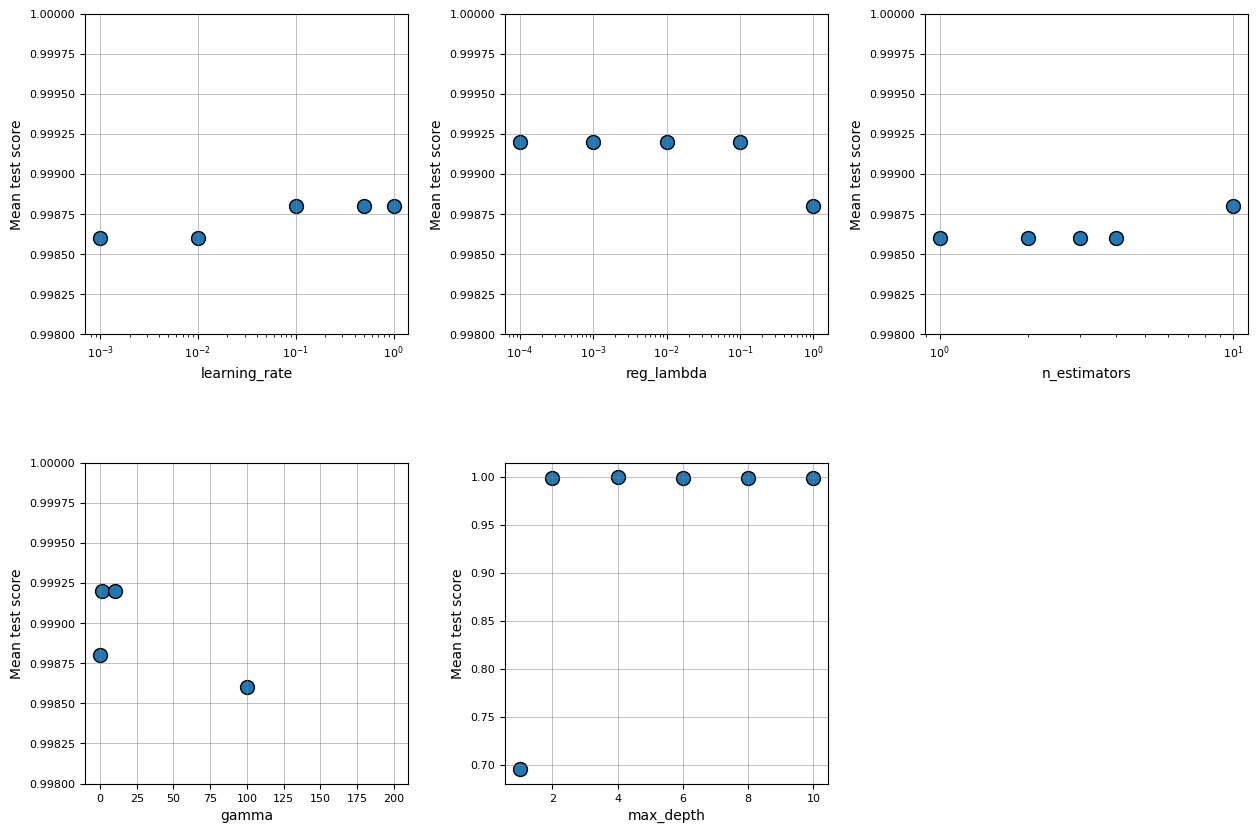

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

x_labels = [next(iter(i)) for i in dicts]
scores, params = np.empty(len(x_labels)), np.empty(len(x_labels),dtype=dict)

for i in range(len(x_labels)):
    scores[i], params[i], df = gridsearch(dicts[i], XGBClassifier(), x_train, y_train)
    axs[i//3, i%3].scatter(list(dicts[i].values()), df['mean_test_score'].T, marker='o', s=100, edgecolors='k')
    axs[i//3, i%3].set_xlabel(x_labels[i], fontsize=10) 
    axs[i//3, i%3].set_ylabel('Mean test score', fontsize=10) 
    axs[i//3, i%3].tick_params(axis='x', labelsize=8) 
    axs[i//3, i%3].tick_params(axis='y', labelsize=8) 
    axs[i//3, i%3].grid(True, linestyle='-', linewidth='0.7', color='gray', alpha=0.5)

    if i != 4:
       axs[i//3, i%3].set_ylim(0.998,1)



# Remove empty subplot
fig.delaxes(axs[1, 2])

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Adapt some scales
axs[0, 0].set_xscale('log')
axs[0, 1].set_xscale('log')
axs[0, 2].set_xscale('log')

Comment on the results. Apart from the maximum depth, the variation of a single parameter at a time does not seem to impact too much on the final accuracy.

XGBoost GridSearch of the entire dictionary

In [18]:
score_xg, params_xg, df_xg = gridsearch(param_grid, XGBClassifier(), x_train, y_train)

In [89]:
print('Best score: ', score_xg)
print('Params: ', params_xg)

Best score:  0.9994000000000001
Params:  {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 10, 'reg_lambda': 1}


Once found the best parameters through the grid search, we try to simplify the model by reducing the number of estimators and the maximum depth.

In [33]:
score = classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.5,
                       reg_lambda=1, n_estimators=2, gamma=0, max_depth = 3),show=False)

In [34]:
print(score)

0.9992


 Comment on the results. We have found that, indeed, with just 2 estimators and a max depth of 3 the result is 0.9992, very close to the one obtained with the optimal combination of the tested parameters.

### AdaBoost

Cite from scikit learn guide: "The main parameters to tune to obtain good results are n_estimators and the complexity of the base estimators (e.g., its depth)."

In [30]:
param_grid_ada = {'algorithm': ['SAMME', 'SAMME.R'],
                  'base_estimator': [DecTree(max_depth=1),DecTree(max_depth=2),DecTree(max_depth=4), DecTree(max_depth=10) ],
                  'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
                  'n_estimators': [1, 2, 3, 4, 10], 
                }

In [31]:
score_ada, params_ada, df_ada = gridsearch(param_grid_ada, AdaBoostClassifier(), x_train, y_train)

In [90]:
print('Best score: ',score_ada)
print(params_ada)

Best score:  0.9992
{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 10}


Now we try to simplify

In [46]:
score_ada = classify(AdaBoostClassifier(algorithm='SAMME', 
                                        base_estimator=DecTree(max_depth=3), 
                                        learning_rate=1, 
                                        n_estimators=3),show=False)

In [47]:
print(score_ada)

0.9992


Comment on the results. Similarly to the previous case, also with AdaBoostClassifier a learning rate of 1 eith 3 estimators and max depth of 3 gives a result extremely close to the one obtained with the optimal combination of the tested parameters.

### GradientBoost

In [48]:
param_grid_grad = {'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
                'n_estimators': [1, 2, 4, 10], 
                'max_depth': [1, 2, 3, 4, 10] 
                }

In [50]:
score_grad, params_grad, df_grad = gridsearch(param_grid_grad, GradientBoostingClassifier(), x_train, y_train)

In [91]:
print('Best score: ',score_grad)
print(params_grad)

Best score:  0.9992000000000001
{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 4}


Now we try to simplify

In [56]:
score_gb = classify(GradientBoostingClassifier(max_depth=3, 
                                               learning_rate=1, 
                                               n_estimators=2),show=False)

In [57]:
print(score_gb)

0.9992


Comment on the results.  Again also in this case with learning rate 1, 2 estimators and max depth 3 we obtain a result extremely close to the optimal one, although seeming slightly slower.

Therefore, we conclude that the simplest model is XGBoost with the following parameters:

-  learning rate = 0.5

- gamma =0

- lambda=1

- number of estimators=2

- maximum depth=3

In fact, it returns an accuracy value (0.9992) extremely close to the values obtained by other combinations. The limiting factors for achieving optimal results rather seem to be the number of estimators (at least 2), the maximum depth (at least 3).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a941f8ac-6dc9-4ab8-b493-b91bd0474306' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>